In [76]:
# Can do this on just one ensemble member and asssume they'll be comparable, or can do individually on ensemble members and average the result
# Calculate a daily climatology
# Look out for leap years
# Subtract the climatology from each year to calculate the daily anomaly
# Linearly detrend
# Calculate the variance and autocorrelation over time
# Start with the 1980-2010 period

import numpy as np
import xarray
from paths import trefhtmn_members, trefhtmx_members, merra2_download
from cftime import DatetimeNoLeap


def calc_variance(xr_ds, years):
    average_year = np.zeros((365, 192, 288))
    for year in years:
        average_year += xr_ds.sel(time=slice(DatetimeNoLeap(year, 1, 1), DatetimeNoLeap(year, 12, 31))).values
    average_year = average_year / len(years)

    avg_yr_anomalies = xr_ds.values * 1
    for year_index in range(len(years)):
        avg_yr_anomalies[365*year_index:365*(year_index+1)] -= average_year

    detrended_anomalies = avg_yr_anomalies
    for lat_index in range(len(xr_ds.lat.values)):
        for lon_index in range(len(xr_ds.lon.values)):
            x_vals = np.linspace(1, detrended_anomalies.shape[0], detrended_anomalies.shape[0])
            coeff = np.polyfit(x_vals, detrended_anomalies[:, lat_index, lon_index], deg=1)
            y_vals = x_vals*coeff[0] + coeff[1]
            detrended_anomalies[:, lat_index, lon_index] -= y_vals
    
    return xarray.DataArray(detrended_anomalies, dims=["time", "lat", "lon"], coords=xr_ds.coords, attrs=xr_ds.attrs)


def calc_variance2(xr_ds, years):
    average_year = np.zeros((365, 361, 576)) # this is different
    for year in years:
        average_year += xr_ds.sel(time=slice(f'{int(year)}-01-01T12:00:00.000000000', f'{int(year)}-12-31T12:00:00.000000000'))[:365].values # this is different
    average_year = average_year / len(years)

    avg_yr_anomalies = xr_ds.values * 1
    for year_index in range(len(years)):
        avg_yr_anomalies[365*year_index:365*(year_index+1)] -= average_year

    detrended_anomalies = avg_yr_anomalies
    for lat_index in range(len(xr_ds.lat.values)):
        for lon_index in range(len(xr_ds.lon.values)):
            x_vals = np.linspace(1, detrended_anomalies.shape[0], detrended_anomalies.shape[0])
            coeff = np.polyfit(x_vals, detrended_anomalies[:, lat_index, lon_index], deg=1)
            y_vals = x_vals*coeff[0] + coeff[1]
            detrended_anomalies[:, lat_index, lon_index] -= y_vals
    
    return xarray.DataArray(detrended_anomalies, dims=["time", "lat", "lon"], coords=xr_ds.coords, attrs=xr_ds.attrs)

sliced = slice(DatetimeNoLeap(1980, 1, 1), DatetimeNoLeap(2015, 12, 31))
trefhtmn = calc_variance(xarray.open_dataset(trefhtmn_members()[0][14])["TREFHTMN"].sel(time=sliced), np.linspace(1980, 2015, 36))
trefhtmx = calc_variance(xarray.open_dataset(trefhtmx_members()[0][14])["TREFHTMX"].sel(time=sliced), np.linspace(1980, 2015, 36))

merramn = calc_variance2(xarray.open_dataset(merra2_download())["T2MMAX"], np.linspace(1980, 2015, 36))
merramx = calc_variance2(xarray.open_dataset(merra2_download())["T2MMIN"], np.linspace(1980, 2015, 36))

Text(0.5, 1.0, 'MERRA2 Maximum')

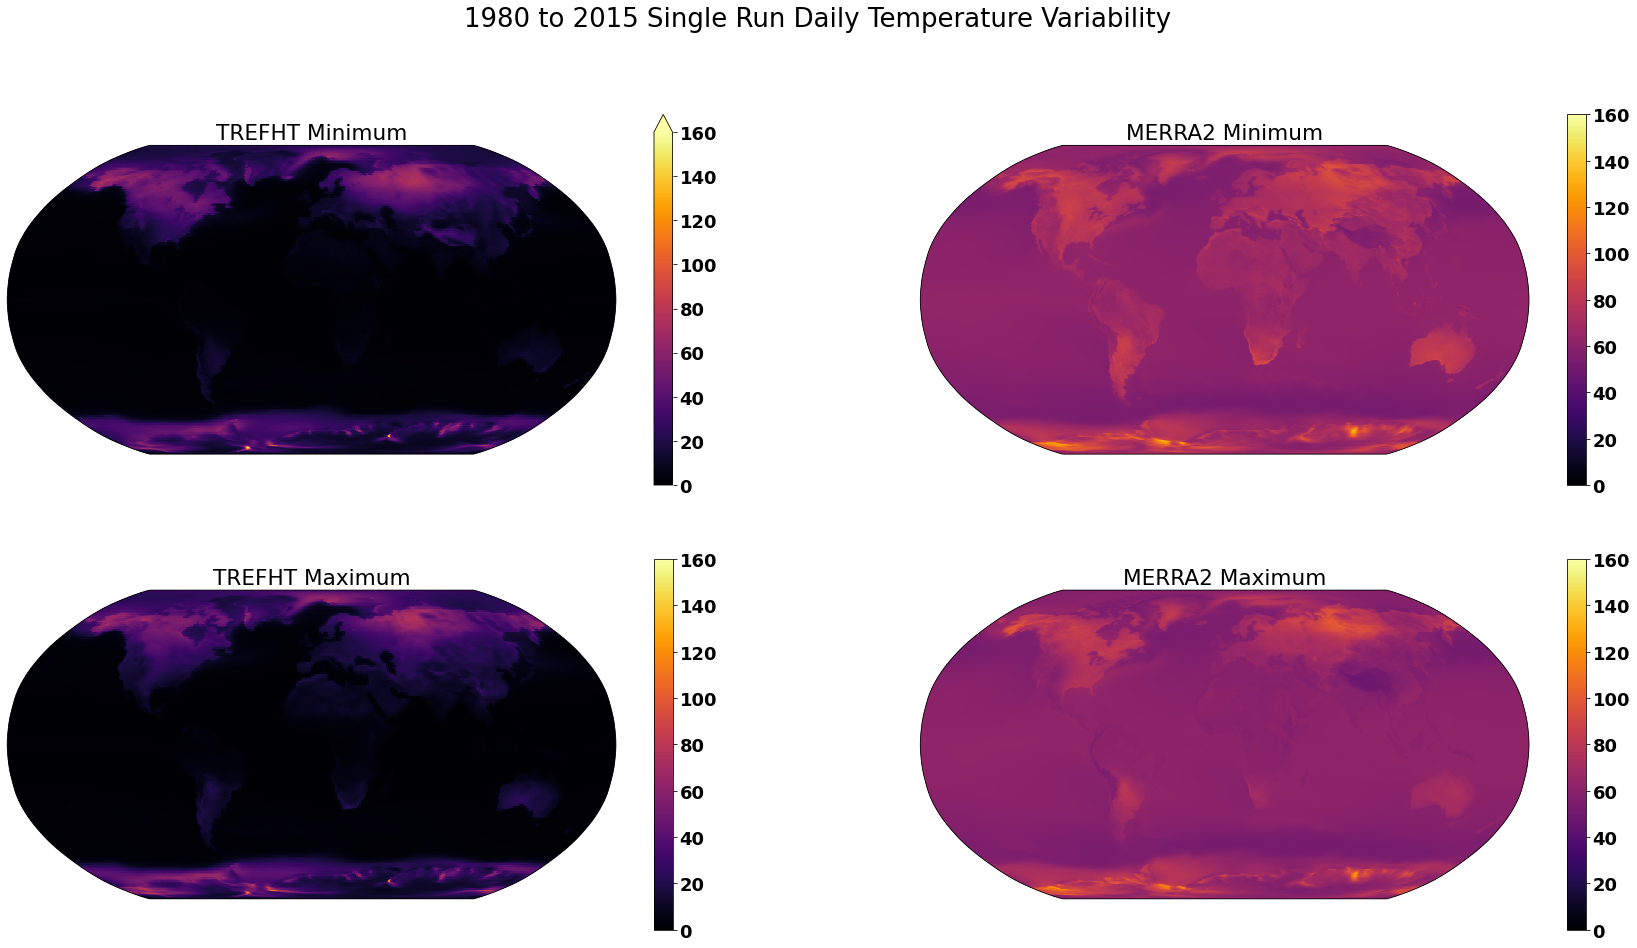

In [77]:
from matplotlib import rc
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

rc('font', **{'weight': 'bold', 'size': 18})
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30, 15), facecolor='w', subplot_kw={'projection': ccrs.Robinson()})
f.suptitle(f"1980 to 2015 Single Run Daily Temperature Variability", fontsize=26)
plt.rcParams['axes.autolimit_mode'] = 'round_numbers'

#land_m = xarray.open_dataset(land_mask())["__xarray_dataarray_variable__"]

cmap="inferno"

trefhtmn.var(dim="time").plot(ax=ax1, cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=160)
trefhtmx.var(dim="time").plot(ax=ax3, cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=160)

merramn.var(dim="time").plot(ax=ax2, cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=160)
merramx.var(dim="time").plot(ax=ax4, cmap=cmap, transform=ccrs.PlateCarree(), vmin=0, vmax=160)

ax1.set_title("TREFHT Minimum")
ax2.set_title("MERRA2 Minimum")
ax3.set_title("TREFHT Maximum")
ax4.set_title("MERRA2 Maximum")

In [ ]:
## Compare the time series data for a single location
